# Benchmarking
This is a simple benchmarking utility to evaluate how much data the user's specific hardware can process at a given time. During such heavy workleads, crashes are common due to overloaded CPU, RAM or storage. This notebook will help to evaluate what size of batch someone should use to limit resource peak usage.

## 1. Setup

In [3]:
# Imports
from PIL import Image
import numpy as np
import matplotlib.pylab as plt
from IPython import display
import gc
import psutil
%matplotlib inline

In [8]:
# User Variables & Parameters
# File Control Pparameters
prec_FileName           = 'wc2.1_2.5m_prec_'
prec_DataPath           = '../../WaterBucket/data/world/wc2.1_2.5m_prec/'
out_PrecPath            = '../../WaterBucket/data/isb/prec/'

                        # (longitude, latitude, Area)
locationCoordiantes     = (73.084488, 33.738045, 0.405)
filePathList            = []

# Benchmark Parameters
sBatches                = 2
nBatches                = sBatches * 3
batchSize               = 12 * sBatches

startYear               = 1961
endYear                 = startYear + (nBatches - 1)
numYears                = (endYear - startYear) + 1
fromMonth               = 1
toMonth                 = 12

# Resource Parameters
limitMemoryPerc         = 90
limitCPUPerc            = 100

In [9]:
# Function to calculate the pixel values from coordinates
def Coordinates2Pixels(coordValX, coordValY, areaVal):

    # Calculating coordinate pixel location 1' coordVal = 24 pixels)
    pixelValX           = int(round( ((180 * 24) + (coordValX * 24)), 0) )
    pixelValY           = int(round( ((90 * 24) - (coordValY * 24)), 0)  )

    # Using area to calculate a box
    radius              = int(round((areaVal * 24), 0))
    heightWidth         = radius * 2
    pixelStartX         = pixelValX - radius
    pixelStartY         = pixelValY - radius

    return (pixelStartX, pixelStartY, heightWidth)

In [10]:
# Generating FilePathList
for y in range(startYear, endYear + 1):
    for m in range(fromMonth, toMonth + 1):

        # Handling case where month name is 01, 02, to 09
        monthName       = ''
        if m < 10:
            monthName   = '0' + str(m)
        else:
            monthName   = str(m)
        
        # Calculaing imagepath and searching if it exists on the system
        fileName        = prec_FileName + str(y) + '-' + str(monthName) + '.tif'
        imagePath       = prec_DataPath + fileName
        filePathList.append(imagePath)

# Calculating picel coordinates
pixelCord               = Coordinates2Pixels(locationCoordiantes[0],
                                            locationCoordiantes[1],
                                            locationCoordiantes[2])

## 2. Benchmark Setup Summary

In [11]:
print('Batch size:\t\t', sBatches, 'year(s)')
print('Number of batches:\t', int(nBatches/sBatches))
print('Processing from:\t', startYear)
print('Processing to:\t\t', endYear)
print('Files to be processed:\t', len(filePathList))
print('Memory Limit:\t\t', limitMemoryPerc, '%')
print('CPU Limit:\t\t', limitCPUPerc, '%')

Batch size:		 2 year(s)
Number of batches:	 3
Processing from:	 1961
Processing to:		 1966
Files to be processed:	 72
Memory Limit:		 90 %
CPU Limit:		 100 %


## 2. Benchmark

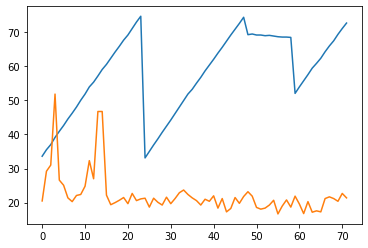

In [12]:
# Batch processing
currentFileList         = [0]
filePathListSize        = len(filePathList)
failSwitch              = False
ramUse                  = []
cpuUse                  = []

# Iterating over each file by batch
fileIndex               = 0
while fileIndex < filePathListSize:

    # File list and paths (RAM) for each batch
    batchFiles          = []
    batchPaths          = []

    # Iterating over the current set of files in batch to load
    for i in range(fileIndex, fileIndex + batchSize):

        # Extra check for last batch if it has less elemments than batch size
        if i < filePathListSize:
            
            # Loading Images
            CurrentImage = Image.open(filePathList[i])
            batchFiles.append(CurrentImage)
            
            genFileName = out_PrecPath + (filePathList[i])[56:]
            batchPaths.append(genFileName)

    print(batchPaths[0], ' to ', batchPaths[-1], '\n')

    # Going over each file of the batch
    for i in range(0, len(batchFiles)):

        # Cropping Image
        CroppedImage    = batchFiles[i].crop((pixelCord[0],
                                            pixelCord[1],
                                            pixelCord[0] + pixelCord[2],
                                            pixelCord[1] + pixelCord[2]))
        
        
        # Calculating current ram and cpu use
        ramUse.append(psutil.virtual_memory().percent)
        cpuUse.append(psutil.cpu_percent())

        # Display
        print('RAM Usage: ', ramUse[-1])
        print('CPU Usage: ', cpuUse[-1])

        # Plotting
        display.clear_output(wait=True)
        plt.plot(currentFileList, ramUse, cpuUse)
        #plt.plot(currentFileList, cpuUse)
        #display.display(plt.gcf())
        plt.show()

        # Updating File Index
        currentFileList.append(currentFileList[-1] + 1)

        # Resource Check
        if (ramUse[-1] > limitMemoryPerc) or (cpuUse[-1] > limitCPUPerc):
            failSwitch = True
            break
        

    if failSwitch == True:
        print('Exceeded Resource Use!!!!')
        break

    # Proceeeding to next batch
    fileIndex = fileIndex + batchSize

In [13]:
# Cleanup
gc.collect()

43613

In [14]:
# Other resource parameters
print(psutil.cpu_percent())
print(psutil.virtual_memory())
print(dict(psutil.virtual_memory()._asdict()))
print(psutil.virtual_memory().percent)
print(psutil.virtual_memory().available * 100 / psutil.virtual_memory().total)

2.7
svmem(total=8196751360, available=2199212032, percent=73.2, used=5636198400, free=137789440, active=1666519040, inactive=5863038976, buffers=8953856, cached=2413809664, shared=52666368, slab=277155840)
{'total': 8196751360, 'available': 2199212032, 'percent': 73.2, 'used': 5636198400, 'free': 137789440, 'active': 1666519040, 'inactive': 5863038976, 'buffers': 8957952, 'cached': 2413805568, 'shared': 52666368, 'slab': 277155840}
73.2
26.79880669211857
